In [6]:
from abc import ABC, abstractmethod

In [7]:
import yfinance as yf
import pandas as pd

In [78]:
tickers = ["AAPL", "MSFT", "GOOG"]
data= yf.download(tickers, start="2023-01-01", end="2024-01-01")['Adj Close']

[*********************100%***********************]  3 of 3 completed


In [75]:
data.head()

Ticker,AAPL,GOOG,MSFT
Date,,,
2023-01-03,123.768448,89.480255,235.711731
2023-01-04,125.045036,88.492676,225.400925
2023-01-05,123.718979,86.557426,218.720551
2023-01-06,128.271088,87.944031,221.298218
2023-01-09,128.795609,88.582466,223.452896


In [10]:
class Asset(ABC):
    def __init__(self, name):
        self.name = name

    @abstractmethod
    def calculate_return(self):
        pass

In [79]:
class Stock(Asset):
    
    def __init__(self, name, prices):
        super().__init__(name)
        self.prices = prices
        
    def calculate_return(self):
        return self.prices.pct_change().dropna()
        

In [80]:
apple_stock_prices = data['AAPL']
microsoft_stock_prices=data['MSFT']
apple=Stock('apple',apple_stock_prices)
microsoft=Stock('microsoft',microsoft_stock_prices)

In [225]:
apple.calculate_return().mean()

0.00183492712468123

## Class Portfolio 

In [272]:
import numpy as np
from scipy.optimize import minimize


class Portfolio():
    def __init__(self):
        self._assets=[]
        self._weights=[]
        
    def get_assets(self):
        return self._assets
    
    
    def set_assets(self, assets):
        if not isinstance(assets, list):
            raise TypeError("Les actifs doivent être une liste.")
        self._assets = assets
        
        
        
    def get_weights(self):
        return self._weights
    

    def set_weights(self, weights):
        if not all(0 <= w <= 1 for w in weights):
            raise ValueError("Les poids doivent être entre 0 et 1.")
        if sum(weights) > 1:
            raise ValueError("La somme des poids ne peut pas dépasser 1.")
        self._weights = weights
        
    
    def add_asset(self,asset,weight):
        self._weights.append(weight)
        if not isinstance(asset, Asset):
            raise TypeError("L'objet ajouté doit être une instance de la classe Asset.")
        self._assets.append(asset)
       
        
        
    def portfolio_summary(self):
        details = "Détail du portefeuille :\n"
        for asset, weight in zip(self._assets, self._weights):
            details += f"- {asset.name}: {weight*100:.2f}%\n"
        return details
    
    
    def portfolio_return(self):
        # Calcul du rendement moyen pondéré
        returns = [asset.calculate_return() for asset in self._assets]
        rendement = sum(weight * returns[i].mean() for i, weight in enumerate(self._weights))
        return rendement
    
    
    def calculate_portfolio_returns(self):

        all_returns = [asset.calculate_return() for asset in self._assets]

        # Combinaison des rendements pondérés
        weighted_returns = np.sum([returns * weight for returns, weight in zip(all_returns, self._weights)], axis=0)
        return weighted_returns
    

    def portfolio_volatility(self):
        returns=np.array([asset.calculate_return() for asset in self._assets])
        weights=np.array(self._weights)
        cov_mat=np.cov(returns)
        return np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
    
    
    ## Optimisation du portfeuille
    ## La méthode suivante optimise les pondérations des actifs pour minimiser le risque pour un rendement donné,
    ##   elle retourne les pondérations optimales pour atteindre le rendement cible
    
    
    def optimize_portfolio(self, target_return):
        ### target_return: Rendement cible du portefeuille
            
    
        # Fonction objectif pour minimiser la volatilité
        def objective(weights):
            returns = np.array([asset.calculate_return().mean() for asset in self._assets])
            cov_mat = np.cov(returns)
            portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
            return portfolio_volatility
    
    
        # Contrainte : le rendement du portefeuille doit être égal au rendement cible
        def return_constraint(weights):
            returns = np.array([asset.calculate_return().mean() for asset in self._assets])
            portfolio_return = np.dot(weights, returns)
            return portfolio_return - target_return
        
        # Contrainte : la somme des pondérations doit être égale à 1
        constraints = ({'type': 'eq', 'fun': return_constraint},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

        # Limites pour les pondérations (entre 0 et 1)
        bounds = [(0, 1) for _ in self._assets]

        # Initialisation des pondérations (également réparties)
        init_weights = np.array([1/len(self._assets) for _ in self._assets])

        # Optimisation des pondérations pour minimiser la volatilité
        result = minimize(objective, init_weights, method='SLSQP', bounds=bounds, constraints=constraints,options={'disp': True,'maxiter': 1000})

        # Enregistrer les pondérations optimales
        if result.success:
            self._weights = result.x
            print(f"Pondérations optimales : {self._weights}")
            return self._weights
        else:
            print("L'optimisation a échoué.")
            return result

  
        
        

### Détails du portefeuille

In [273]:
portfolio = Portfolio()
portfolio.add_asset(apple,0.5)
portfolio.add_asset(microsoft,0.5)
## Détail du portfeuille
print(portfolio.portfolio_summary())
##Rendement du portfeuille
print(f"Rendement: {portfolio.portfolio_return()}")
## Volatilité du portfeuille
print(f"Volatilité:{portfolio.portfolio_volatility()}")

Détail du portefeuille :
- apple: 50.00%
- microsoft: 50.00%

Rendement: 0.001903293818325436
Volatilité:0.01251418285559693


### Optimisation du portfeuille pour un rendement cible de 0.02

In [229]:
target_return = 0.00191
optimal_weights = portfolio.optimize_portfolio(target_return)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.869481538851755e-05
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Pondérations optimales : [0.45095433 0.54904567]


### Avant de calculer la Var du portfeuille, analysons la distribution des rendments de chaque actifs

In [19]:
from scipy.stats import shapiro, normaltest

In [20]:
import matplotlib.pyplot as plt

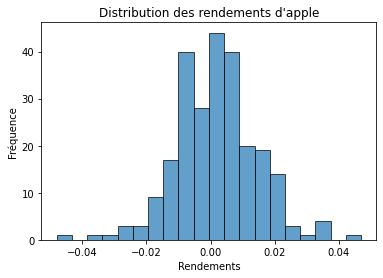

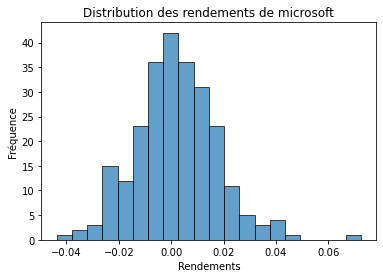

In [230]:
# Histogramme des rendements
apple_returns=apple.calculate_return().dropna()
plt.hist(apple_returns, bins=20, edgecolor='k', alpha=0.7)
plt.title("Distribution des rendements d'apple")
plt.xlabel("Rendements")
plt.ylabel("Fréquence")
plt.show()

# Histogramme des rendements
microsoft_returns=microsoft.calculate_return().dropna()
plt.hist(microsoft_returns, bins=20, edgecolor='k', alpha=0.7)
plt.title("Distribution des rendements de microsoft")
plt.xlabel("Rendements")
plt.ylabel("Fréquence")
plt.show()

In [232]:
#  Test de Shapiro-Wilk pour tester la normalité des rendemets
shapiro_stat, shapiro_p = shapiro(microsoft_returns)
print(f"Shapiro-Wilk Test: Statistique={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("Les rendements de microsoft suivent une distribution normale (p > 0.05).")
else:
    print("Les rendements de microsoft ne suivent pas une distribution normale (p <= 0.05).")


Shapiro-Wilk Test: Statistique=0.9855, p-value=0.0124
Les rendements de microsoft ne suivent pas une distribution normale (p <= 0.05).


In [231]:
# 1. Test de Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(apple_returns)
print(f"Shapiro-Wilk Test: Statistique={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("Les rendements d'apple  suivent une distribution normale (p > 0.05).")
else:
    print("Les rendements d'apple ne suivent pas une distribution normale (p <= 0.05).")


Shapiro-Wilk Test: Statistique=0.9857, p-value=0.0137
Les rendements d'apple ne suivent pas une distribution normale (p <= 0.05).


In [244]:
shapiro_stat, shapiro_p = shapiro(portfolio_returns)
print(f"Shapiro-Wilk Test: Statistique={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("Les rendements  suivent une distribution normale (p > 0.05).")
else:
    print("Les rendements ne suivent pas une distribution normale (p <= 0.05).")


Shapiro-Wilk Test: Statistique=0.9944, p-value=0.4824
Les rendements  suivent une distribution normale (p > 0.05).


###  QQ-plot pour comparer la distribution empirique avec une distribution normale.

In [26]:
import statsmodels.api as sm

C:\Users\tarik\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


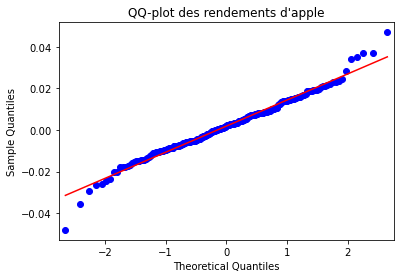

C:\Users\tarik\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


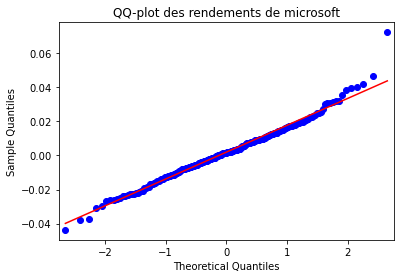

In [233]:

sm.qqplot(apple_returns, line='s')
plt.title("QQ-plot des rendements d'apple")
plt.show()
sm.qqplot(microsoft_returns, line='s')
plt.title("QQ-plot des rendements de microsoft")
plt.show()

##### Skewness is the third moment of a distribution after mean and variance.
Negative skew: The mass of the distribution is concentrated on the right. Usually a right-leaning curve.

Positive skew: The mass of the distribution is concentrated on the left. Usually a left-leaning curve.

In finance, we would tend to want a positive skewness.

In [32]:
from scipy.stats import skew, kurtosis

print(f"Skewness : {skew(apple_returns.dropna())}")  

Skewness : 0.011689421693552004


In [33]:
print(f"Kurtosis : {kurtosis(apple_returns.dropna())}")  

Kurtosis : 1.3802884319996434


#### Ajuster une loi de student sur les rendements d'apple

Le fait d'ajuster une loi (comme la loi t de Student) aux rendements signifie qu'on utilise cette loi pour modéliser les données. Cela se fait en estimant les paramètres de la loi (par exemple, degrés de liberté, moyenne, écart-type) pour qu'elle corresponde au mieux à la distribution observée des rendements (qui ne suivent pas une distribution normale).

L'objectif est de trouver les paramètres optimaux de la loi t de Student (ν,μ,σ) pour qu'elle représente les rendements réels.

La fonction t.fit estime les paramètres suivants :
ν (degrés de liberté) : contrôle l'épaisseur des queues.
μ (loc) : la moyenne des rendements ajustés.
σ (scale) : l'écart-type ajusté.

Degrés de liberté (df): 7.327061481775338, Location (loc): 0.0017600216212331587, Scale: 0.010701322164030233


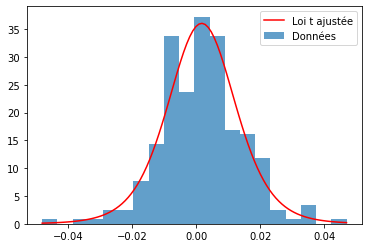

In [41]:
from scipy.stats import t,norm

# Ajuster une loi t de Student sur les rendements d'apple
data = apple_returns 
df, loc, scale = t.fit(data)  # Paramètres de la loi t
print(f"Degrés de liberté (df): {df}, Location (loc): {loc}, Scale: {scale}")

# Comparer la densité des rendements avec la loi t ajustée

x = np.linspace(min(data), max(data), 100)
pdf = t.pdf(x, df, loc, scale)
plt.hist(data, bins=20, density=True, alpha=0.7, label="Données")
plt.plot(x, pdf, label="Loi t ajustée", color="red")
plt.legend()
plt.show()

### Ajustement de la VaR et de la CVaR

In [240]:
# Simuler des rendements non normaux (par exemple, loi t)
returns = apple_returns  # Rendements 

# Ajuster les paramètres de la loi t
df, loc, scale = t.fit(returns)

# Calcul de la VaR pour cette distribution
# La VaR à un niveau α est le quantile q=α d'une distribution de pertes
alpha=0.05
VaR_t = t.ppf(0.05, df, loc, scale)

# Calcul de la CVaR pour cette distribution
CVaR_t = t.expect(lambda x: x, args=(df,), lb=-np.inf, ub=VaR, loc=loc, scale=scale) / alpha

print(f"VaR (ajustée) : {VaR_t:.4f}")
print(f"CVaR (ajustée) : {CVaR_t:.4f}")

VaR (ajustée) : -0.0184
CVaR (ajustée) : -0.0240


# Calcul de la Var et de la CVaR du portfeuille

## VaR Historique

In [236]:
portfolio_returns.shape

(249,)

In [267]:
### VAR HISTORIQUE
# Définir le niveau de confiance
# Pour un niveau de confiance de 95 %, le seuil est 5 %
VaR = np.percentile(portfolio_returns, 5)
print(f"Il y a 5% de chance que la perte soit supérieur à {-VaR* 100:.2f}% la valeur du portfeuille")

Il y a 5% de chance que la perte soit supérieur à 1.90% la valeur du portfeuille


In [279]:
CVaR=portfolio_returns[portfolio_returns<VaR].mean()
print(f"CVaR à {confidence_level * 100}% : {CVaR*100:.2f}%")

CVaR à 5.0% : -2.18%


## Var Parametrique

In [285]:
mean=portfolio.portfolio_return()
quantile=norm.ppf(0.95, loc =0, scale = 1)
std=portfolio.portfolio_volatility()
VaRp=-(mean+quantile*std)
print(f"Il y a 5% de chance que la perte soit supérieur à {-VaRp* 100:.2f}% la valeur du portfeuille")

Il y a 5% de chance que la perte soit supérieur à 2.25% la valeur du portfeuille


In [287]:
CVaRp=portfolio_returns[portfolio_returns<VaRp].mean()
print(f"CVaR à {confidence_level * 100}% : {CVaRp*100:.4f}%")

CVaR à 5.0% : -2.6226%


### Visualiser les seuils de VaR et CVaR sur la distribution des rendements

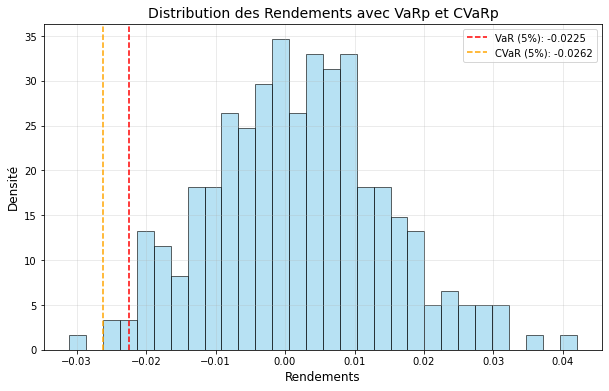

In [288]:
# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Ajouter une ligne verticale pour la VaR
plt.axvline(VaRp, color='red', linestyle='--', label=f"VaR ({alpha*100:.0f}%): {VaRp:.4f}")

# Ajouter une ligne verticale pour la CVaR
plt.axvline(CVaRp, color='orange', linestyle='--', label=f"CVaR ({alpha*100:.0f}%): {CVaRp:.4f}")

# Ajouter des annotations
plt.title("Distribution des Rendements avec VaRp et CVaRp", fontsize=14)
plt.xlabel("Rendements", fontsize=12)
plt.ylabel("Densité", fontsize=12)
plt.legend(fontsize=10)

# Afficher le graphique
plt.grid(alpha=0.3)
plt.show()

VaR (ligne rouge) :

Indique la perte maximale pour un niveau de confiance donné (α=5%).
Tout ce qui est à gauche de cette ligne représente des pertes extrêmes au-delà du seuil.
CVaR (ligne orange) :

Représente la perte moyenne conditionnelle au dépassement de la VaR.
Elle est plus négative que la VaR, car elle inclut toutes les pertes extrêmes.


In [ ]:
# Boucle sur différents niveau de confiance
#for cl, VaR in zip (confidence_levels, VaRs):
#    plt.axvline (x=-VaR, linestyle='-', color='r', label='VaR at {} % Confidence'.format(int(cl* 100)))



Degrés de liberté (df): 127634.7461367246, Location (loc): 0.0019033352088609265, Scale: 0.012488945125958759


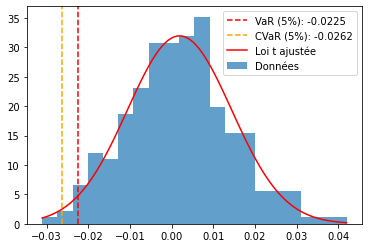

In [290]:
from scipy.stats import t,norm

# Ajuster une loi t de Student sur les rendements
data = portfolio_returns 
df, loc, scale = t.fit(data)  # Paramètres de la loi t
print(f"Degrés de liberté (df): {df}, Location (loc): {loc}, Scale: {scale}")

x = np.linspace(min(data), max(data), 100)
pdf = t.pdf(x, df, loc, scale)
plt.hist(data, bins=20, density=True, alpha=0.7, label="Données")
# Ajouter une ligne verticale pour la VaR
plt.axvline(VaRp, color='red', linestyle='--', label=f"VaR ({alpha*100:.0f}%): {VaRp:.4f}")
# Ajouter une ligne verticale pour la CVaR
plt.axvline(CVaRp, color='orange', linestyle='--', label=f"CVaR ({alpha*100:.0f}%): {CVaRp:.4f}")
plt.plot(x, pdf, label="Loi t ajustée", color="red")
plt.legend()
plt.show()